# Handle Imports

This is setup in a way that (hopefully) allows one to both run this notebook in Colab (Pro version) as well as locally if they have a beefy GPU.

In [1]:
try:
    import google.colab
    USING_COLAB = True
except:
    USING_COLAB = False

In [2]:
if USING_COLAB:
    !pip install transformers
    !pip install diffusers
    !pip install folium==0.9.1
    !pip install huggingface-hub
    !pip install pillow==9.0.0
    !pip install scikit-image==0.19.2
    !pip install accelerate
    !pip install safetensors
    !pip install sentencepiece
    !pip install -U xformers
else:
    print("Assuming you have installed the mcmc_visanagrams package.")

Assuming you have installed the mcmc_visanagrams package.


In [3]:
# Separating out the installation of the mcmc_visanagrams package so that it can be re-installed as
# needed without re-installing all the other packages (or checking for them).
if USING_COLAB:
    # NOTE: You might be able to install this as an editable pip package with the `-e` flag (before
    # the URL), meaning that you could potentially edit the package while working in Colab and
    # push the changes to GitHub. This would circumvent the need to push code before testing it.
    !pip install git+https://github.com/joshroy01/mcmc_visanagrams.git@implement_superres_composed_embeddings

In [4]:
if USING_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

In [6]:
from pathlib import Path

import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torch import autocast
from diffusers import DDIMScheduler, DiffusionPipeline

from mcmc_visanagrams.pipelines.if_pipeline import IFPipeline

from mcmc_visanagrams.utils.display import visualize_context

# Code for Samplers
from mcmc_visanagrams.samplers.annealed_ula_sampler import AnnealedULASampler
from mcmc_visanagrams.samplers.annealed_uha_sampler import AnnealedUHASampler

from mcmc_visanagrams.utils.output import load_context

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
from huggingface_hub import notebook_login

notebook_login()

In [8]:
# STAGE_1_PRETRAINED_MODEL_ID = "DeepFloyd/IF-I-XL-v1.0"
STAGE_1_PRETRAINED_MODEL_ID = "DeepFloyd/IF-I-M-v1.0"
# STAGE_2_PRETRAINED_MODEL_ID = "DeepFloyd/IF-II-L-v1.0"
STAGE_2_PRETRAINED_MODEL_ID = "DeepFloyd/IF-II-M-v1.0"

# **MCMC Sampling to Generate Tapestries**

In [11]:
if USING_COLAB:
    context_path = Path("context.json")
    latents_path = Path("latents.pt")
else:
    context_path = Path("data/single_prompt/context.json")
    latents_path = Path("data/single_prompt/latents.pt")

# Load data that would have been generated in stage 1
context = load_context(context_path)
latents = torch.load(latents_path)

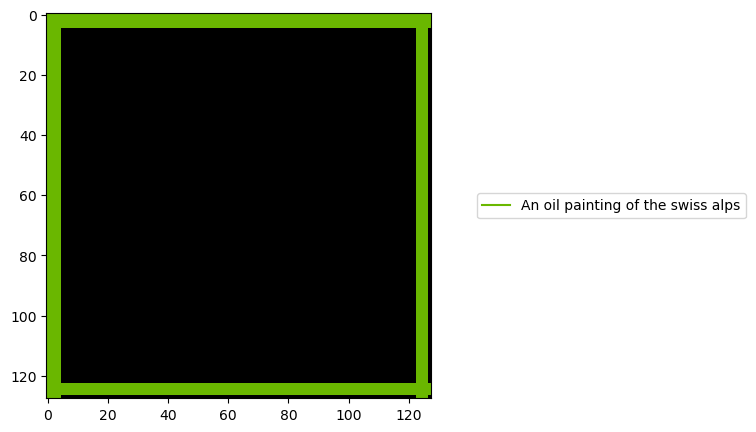

In [12]:
guidance_mag = 20.0

color_lookup = {}
np.random.seed(1)
for k, v in context.items():
    color_lookup[v['string']] = (np.random.uniform(size=(3, )), k[0]**2)

plt.figure(figsize=(5, 5))
img = visualize_context(128, 64, context, color_lookup)

plt.imshow(img)

for k, v in context.items():
    scale, xstart, ystart = k
    caption = v['string']
    color = color_lookup[caption][0]
    plt.plot([], [], color=color, label=caption)

plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))

plt.savefig('composite_captions.pdf', bbox_inches='tight')
plt.savefig('composite_captions.png', bbox_inches='tight', facecolor=plt.gca().get_facecolor())
# %download_file composite_captions.pdf
# %download_file composite_captions.png

In [13]:
has_cuda = torch.cuda.is_available()
device = torch.device('cpu' if not has_cuda else 'cuda')
print(device)

# We still initialize stage 1 since I haven't implemented saving of the embeddings from stage 1.
stage_1 = IFPipeline.from_pretrained(STAGE_1_PRETRAINED_MODEL_ID,
                                     variant="fp16",
                                     torch_dtype=torch.float16,
                                     use_auth_token=True)
stage_1.enable_xformers_memory_efficient_attention()
stage_1.enable_model_cpu_offload()
stage_1.safety_checker = None

safety_checker/model.safetensors not found

A mixture of fp16 and non-fp16 filenames will be loaded.
Loaded fp16 filenames:
[text_encoder/pytorch_model.fp16-00001-of-00002.bin, unet/diffusion_pytorch_model.fp16.bin, text_encoder/pytorch_model.fp16-00002-of-00002.bin]
Loaded non-fp16 filenames:
[watermarker/diffusion_pytorch_model.bin, safety_checker/pytorch_model.bin
If this behavior is not expected, please check your folder structure.
Keyword arguments {'use_auth_token': True} are not expected by IFPipeline and will be ignored.


cuda


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [14]:
num_steps = 1000

# increase the number of Langevin MCMC steps run to sample between intermediate distributions
# more steps improves sampling quality
# la_steps = 10
# la_steps = 15
la_steps = 20

la_step_sizes = stage_1.scheduler.betas * 2

alphas = 1 - stage_1.scheduler.betas
alphas_cumprod = np.cumprod(alphas)
scalar = np.sqrt(1 / (1 - alphas_cumprod))

la_sampler = AnnealedULASampler(num_steps, la_steps, la_step_sizes, None, None, None)

In [15]:
seed = 0
# Number of intermediate transition distributions to specify
steps = 100

generator = torch.Generator('cuda').manual_seed(seed)

# with torch.no_grad():
#     latents = stage_1(context,
#                       la_sampler,
#                       height=128,
#                       width=128,
#                       generator=generator,
#                       num_inference_steps=steps)

In [16]:
image = latents[0].cpu().numpy().transpose(1, 2, 0)
image = ((image + 1) / 2 * 255)

print(image.max())
print(image.min())

SHOW_CHANNELWISE_IMAGE = False
if SHOW_CHANNELWISE_IMAGE:
    plt.figure()
    plt.imshow(image[..., 0])

    plt.figure()
    plt.imshow(image[..., 1])

    plt.figure()
    plt.imshow(image[..., 2])

256.68015
-1.6801482


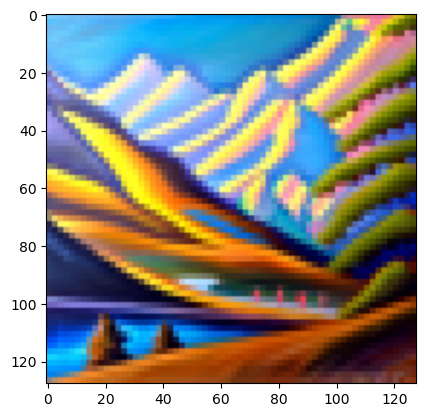

In [17]:
import matplotlib.pyplot as plt
# from imageio import imwrite

image = latents[0].cpu().numpy().transpose(1, 2, 0)
image = ((image + 1) / 2 * 255)

CLIP_DYNAMIC_RANGE = True
if CLIP_DYNAMIC_RANGE:
    image[image < 0.0] = 0.0
    image[image > 255] = 255

image = image.astype(np.uint8)
# imwrite("test.png", image)
plt.imshow(image)

In [18]:
from mcmc_visanagrams.pipelines.if_super_resolution_pipeline import IFSuperResolutionPipeline

# stage_2 = DiffusionPipeline.from_pretrained(STAGE_2_PRETRAINED_MODEL_ID,
stage_2 = IFSuperResolutionPipeline.from_pretrained(STAGE_2_PRETRAINED_MODEL_ID,
                                                    text_encoder=None,
                                                    variant="fp16",
                                                    torch_dtype=torch.float16)
stage_2.enable_xformers_memory_efficient_attention()
stage_2.enable_model_cpu_offload()


A mixture of fp16 and non-fp16 filenames will be loaded.
Loaded fp16 filenames:
[unet/diffusion_pytorch_model.fp16.safetensors, text_encoder/model.fp16-00001-of-00002.safetensors, safety_checker/model.fp16.safetensors, text_encoder/model.fp16-00002-of-00002.safetensors]
Loaded non-fp16 filenames:
[watermarker/diffusion_pytorch_model.safetensors
If this behavior is not expected, please check your folder structure.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [19]:
# This is changed from the original notebook. They were conditioning the stage 2 diffusion of
# DeepFloyd on an empty string which seems a bit ridiculous to me. As an intermediate stage, I'm
# conditioning Stage 2 on the first context's string.
# prompt = ""
# prompt = context[(2, 0, 0)]["string"]
# prompt_embeds, negative_embeds = stage_1.encode_prompt(prompt)
from mcmc_visanagrams.utils.latents import extract_latents_stage_2

stage_2.text_encoder = stage_1.text_encoder
images = stage_2(
    image=latents,
    context=context,
    sampler=la_sampler,
    #  prompt_embeds=prompt_embeds,
    #  negative_prompt_embeds=negative_embeds,
    generator=generator,
    output_type="pt").images



Setting `clean_caption=True` requires the Beautiful Soup library but it was not found in your environment. You can install it with pip:
`pip install beautifulsoup4`. Please note that you may need to restart your runtime after installation.

Setting `clean_caption` to False...



Setting `clean_caption=True` requires the Beautiful Soup library but it was not found in your environment. You can install it with pip:
`pip install beautifulsoup4`. Please note that you may need to restart your runtime after installation.

Setting `clean_caption` to False...


  0%|          | 0/50 [00:00<?, ?it/s]

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 128 but got size 256 for tensor number 1 in the list.

0.0
255.0


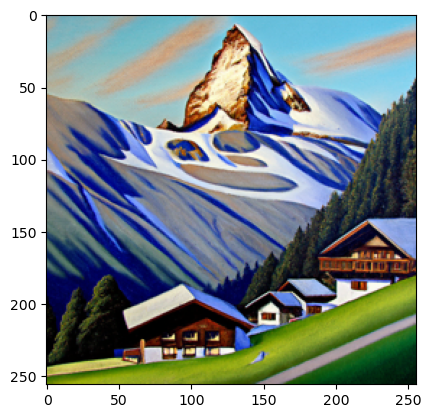

In [24]:
# save upsampled image
if not isinstance(images, np.ndarray):
    images = images[0].cpu().numpy().transpose(1, 2, 0)
    images = ((images + 1) / 2 * 255)

if CLIP_DYNAMIC_RANGE:
    images[images < 0.0] = 0.0
    images[images > 255] = 255

print(images.min())
print(images.max())

images = images.astype(np.uint8)
plt.imshow(images)

In [25]:
# np.save("oil_painting_swiss_alps_no_composed_diffusion_2.npy", images)